In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig


In [2]:
!pip install --upgrade azureml-train-automl-client

Requirement already up-to-date: azureml-train-automl-client in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.16.0)


In [3]:
azureml.core.VERSION

'1.16.0'

In [4]:
ws=Workspace.from_config()
experiment_name = "automl-ogforecasting"
experiment = Experiment(ws,experiment_name)

output={}
output["subscription ID"]=ws.subscription_id
output["Workspace"]=ws.name
output["SKU"]=ws.sku
output["Resource Group"]=ws.resource_group
output["Location"]=ws.location
output["Run History Name"]=experiment_name
pd.set_option('display.max_colwidth',-1)
outputDf=pd.DataFrame(data=output, index=[''])
outputDf.T

,
subscription ID,564cf816-26c7-4ae0-80d2-61523bedd56e
Workspace,Economics
SKU,Basic
Resource Group,MMF1922
Location,eastus
Run History Name,automl-ogforecasting


In [5]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
amlcompute_cluster_name="og-cluster"

try:
    compute_target=ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2', max_nodes=6)
    compute_target=ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [6]:
time_column_name = 'day_datetime'
data=pd.read_csv('rawdata.csv', parse_dates=[time_column_name])
data.head()

,day_datetime,USA GDP QOQ,CAN GDP QOQ,USA Fed Funds Q,Canada Overnight Rate,USA 3-mo Bond Yield,Canada Output Gap,USA Nominal Output Gap,Canada CPI,USA CPI,Canada Housing Price Index,USA Housing Price index
0,1961-06-30,7.0,7.661,1.73,6.75,2.27,3.7,-2.814,15.7,15.7,29.84,38.2
1,1961-09-30,7.9,12.059,1.88,6.75,2.28,3.7,-1.953,15.7,15.7,29.98,38.2
2,1961-12-31,8.1,0.824,2.33,6.75,2.73,3.7,-1.021,15.7,15.7,30.01,38.2
3,1962-03-31,7.3,7.889,2.85,6.75,2.74,3.7,-0.281,15.7,15.7,30.17,38.2
4,1962-06-30,3.7,3.250,2.68,6.75,2.86,3.7,-0.430,15.9,15.9,30.21,38.2


In [7]:
data["day_datetime"] = pd.to_datetime(data["day_datetime"])

In [8]:
n_test_periods=14

def split_last_n(df,n):
    df_head=df.apply(lambda dfg: dfg.iloc[:-n])
    df_tail=df.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail
    
train, test=split_last_n(data, n_test_periods)

In [9]:
test.head()

,day_datetime,USA GDP QOQ,CAN GDP QOQ,USA Fed Funds Q,Canada Overnight Rate,USA 3-mo Bond Yield,Canada Output Gap,USA Nominal Output Gap,Canada CPI,USA CPI,Canada Housing Price Index,USA Housing Price index
222,2016-12-31,2.5,2.271,0.54,0.50,0.5127,-2.1,-1.053,128.4,128.4,242.712,100.0
223,2017-03-31,2.3,4.684,0.79,0.50,0.7516,-1.3,-0.854,129.9,129.9,243.721,100.7
224,2017-06-30,1.7,4.803,1.04,0.50,1.0113,-0.5,-0.851,130.4,130.4,244.179,102.4
225,2017-09-30,2.9,1.444,1.15,1.00,1.1312,-0.5,-0.568,130.8,130.8,246.445,103.1
226,2017-12-31,3.9,1.744,1.30,1.25,1.4551,-0.5,-0.057,130.8,130.8,247.847,103.3


In [10]:
train.to_csv(r'./rawdata_OG_train.csv', index=None)
test.to_csv(r'./rawdata_OG_test.csv',index=None)

In [11]:
datastore=ws.get_default_datastore()
datastore.upload_files(files=['./rawdata_OG_train.csv', './rawdata_OG_test.csv'], target_path = 'dataset/', overwrite=True)

Uploading an estimated of 2 files
Uploading ./rawdata_OG_train.csv
Uploaded ./rawdata_OG_train.csv, 1 files out of an estimated total of 2
Uploading ./rawdata_OG_test.csv
Uploaded ./rawdata_OG_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_ac7563a4574740bab74183a8f1bdcd8f

In [12]:
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('dataset/rawdata_OG_train.csv'))


In [13]:
train_dataset.to_pandas_dataframe().tail()

,day_datetime,USA GDP QOQ,CAN GDP QOQ,USA Fed Funds Q,Canada Overnight Rate,USA 3-mo Bond Yield,Canada Output Gap,USA Nominal Output Gap,Canada CPI,USA CPI,Canada Housing Price Index,USA Housing Price index
217,2015-09-30,1.5,1.419,0.14,0.5,-0.0203,-2.0,-1.251,127.1,127.1,237.498,96.6
218,2015-12-31,0.6,0.301,0.24,0.5,0.1627,-2.3,-1.497,126.5,126.5,237.761,97.0
219,2016-03-31,2.3,2.210,0.36,0.5,0.1983,-2.2,-1.321,127.9,127.9,237.990,97.5
220,2016-06-30,1.3,-1.954,0.38,0.5,0.2587,-3.0,-1.403,129.1,129.1,240.144,98.6
221,2016-09-30,2.2,4.197,0.40,0.5,0.2739,-2.4,-1.289,128.8,128.8,241.068,99.3


In [14]:
target_column_name = "CAN GDP QOQ"

In [15]:
time_series_settings={
    'time_column_name':time_column_name,
    'max_horizon':n_test_periods
}

automl_config=AutoMLConfig(task="forecasting",debug_log="automl_og_errors.log",primary_metric='normalized_mean_absolute_error', experiment_timeout_hours=0.5, training_data=train_dataset, label_column_name=target_column_name, compute_target=compute_target, enable_early_stopping=True, n_cross_validations=3, verbosity=logging.INFO, **time_series_settings)


In [16]:
remote_run=experiment.submit(automl_config, show_output=False)
remote_run

Running on remote.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-ogforecasting,AutoML_c574620d-324d-4f8a-a576-1392346bfa04,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
best_run, fitted_model = remote_run.get_output()
print(fitted_model.steps)
model_name=best_run.properties['model_name']

[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
                      pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('7',
                                          Pipeline(memory=None,
                                                   steps=[('standardscalerwrapper',
                                                           <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7fec5720f978>),
                                                          ('elasticnet',
                                                           ElasticNet(alpha=0.9474210526315789,
                                                                      copy_X=True,
                                                                      fit_intercept=True,
                                                                      l1_ratio=0.01,
                                          

In [18]:
custom_featurizer=fitted_model.named_steps['timeseriestransformer']

In [19]:
custom_featurizer.get_featurization_summary()

[{'RawFeatureName': 'USA GDP QOQ',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'USA Fed Funds Q',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'Canada Overnight Rate',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'USA 3-mo Bond Yield',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'Canada Output Gap',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 2,
  'Transformations': ['MedianImputer', 'ImputationMarker']},
 {'RawFeatureName': 'USA Nominal Output Gap',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  '

In [20]:
X_test=test
y_test=X_test.pop(target_column_name).values
X_test.head()

,day_datetime,USA GDP QOQ,USA Fed Funds Q,Canada Overnight Rate,USA 3-mo Bond Yield,Canada Output Gap,USA Nominal Output Gap,Canada CPI,USA CPI,Canada Housing Price Index,USA Housing Price index
222,2016-12-31,2.50,0.54,0.50,0.51,-2.10,-1.05,128.40,128.40,242.71,100.00
223,2017-03-31,2.30,0.79,0.50,0.75,-1.30,-0.85,129.90,129.90,243.72,100.70
224,2017-06-30,1.70,1.04,0.50,1.01,-0.50,-0.85,130.40,130.40,244.18,102.40
225,2017-09-30,2.90,1.15,1.00,1.13,-0.50,-0.57,130.80,130.80,246.44,103.10
226,2017-12-31,3.90,1.30,1.25,1.46,-0.50,-0.06,130.80,130.80,247.85,103.30


In [21]:
y_predictions, X_trans = fitted_model.forecast(X_test)

In [22]:
import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset


def align_outputs(y_predicted, X_trans, X_test, y_test, target_column_name,
                  predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """

    if (horizon_colname in X_trans):
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted,
                                horizon_colname: X_trans[horizon_colname]})
    else:
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted})

    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index

    # align original X_test to y_test
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')

    # drop rows where prediction or actuals are nan
    # happens because of missing actuals
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name,
                               predicted_column_name]].notnull().all(axis=1)]
    return(clean)

In [23]:
#from forecasting_helper import align_outputs
df_all=align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

WARNING - azureml.automl.runtime.shared.metrics.compute_metrics_regression is deprecated. Please use azureml.automl.runtime.shared.score.scoring.score_regression


[Test data scores]

r2_score:   0.382
root_mean_squared_log_error:   nan
normalized_median_absolute_error:   0.066
normalized_mean_absolute_error:   0.120
normalized_root_mean_squared_log_error:   nan
spearman_correlation:   -0.270
root_mean_squared_error:   2.309
normalized_root_mean_squared_error:   0.178
explained_variance:   0.395
mean_absolute_error:   1.559
mean_absolute_percentage_error:   57.273
median_absolute_error:   0.850


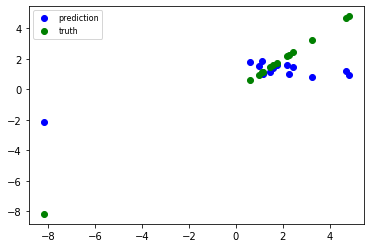

In [24]:
from azureml.automl.core._vendor.automl.client.core.common import metrics
from matplotlib import pyplot as plt
from automl.client.core.common import constants

# use automl metrics module
scores = metrics.compute_metrics_regression(
    df_all['predicted'],
    df_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None, None, None)

print("[Test data scores]\n")
for key, value in scores.items():   
    print('{}:   {:.3f}'.format(key, value))

# Plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [25]:
description='AutoML OG forecaster'
tags=None
model=remote_run.register_model(model_name=model_name, description=description, tags=tags)
print(remote_run.model_id)

AutoMLc574620d330


In [26]:
script_file_name='score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py',script_file_name)

In [27]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), entry_script = script_file_name)
aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1,memory_gb = 2,tags = {'type': "automl-forecasting"},description = "Automl forecasting sample service")
aci_service_name = 'automl-og-forecast-03'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)

aci_service.wait_for_deployment(True)
print(aci_service.state)
aci_service.get_logs()

automl-og-forecast-03
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...........................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


'2020-10-22T23:47:06,456036693+00:00 - iot-server/run \n2020-10-22T23:47:06,468369683+00:00 - gunicorn/run \n2020-10-22T23:47:06,477315476+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_912ebce86aa851a4f789bc2c01e320a3/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_912ebce86aa851a4f789bc2c01e320a3/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_912ebce86aa851a4f789bc2c01e320a3/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_912ebce86aa851a4f789bc2c01e320a3/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_912ebce86aa851a4f789bc2c01e320a3/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n2020-10-22T23:47:06,486122469+00:00 - rsyslog/run 

from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import model_name_validation

InferenceConfig=InferenceConfig(enviroment=best_run.get_enviroment(), entry_script=script_file_name)

aciconfig=AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=2, tags={'type':"automl-forecasting"}, description='Automl forecasting sample service')

aci_service_name='automl-og-forecast-01'
print(aci_service_name)
aci_service=Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)


In [28]:
import json
# The request data frame needs to have y_query column which corresponds to query.
X_query = test.copy()
X_query['y_query'] = np.NaN

# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)

# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)

# translate from networkese to datascientese
try:
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']   

except:
    print(res_dict)


import json
X_query=X_test.copy()
X_query[time_column_name]=X_query[time_column_name].astype(str)
test_sample=json.dumps({'data':X_query.to_dict(orient='records')})
response=aci_service.run(input_data=test_sample)
try:
    res_dict=json.loads(response)
    y_fcst_all=pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name]=pd.to_datetime(y_fcst_all[time_column_name], unit='ms')
    y_fcst_all['forecast']=res_dict['forecast']
except:
    print(res_dict)

In [29]:
y_fcst_all.head(n_test_periods)

,day_datetime,_automl_dummy_grain_col,forecast
0,2016-12-31,_automl_dummy_grain_col,1.00
1,2017-03-31,_automl_dummy_grain_col,1.17
2,2017-06-30,_automl_dummy_grain_col,0.97
3,2017-09-30,_automl_dummy_grain_col,1.08
4,2017-12-31,_automl_dummy_grain_col,1.59
5,2018-03-31,_automl_dummy_grain_col,1.68
6,2018-06-30,_automl_dummy_grain_col,1.38
7,2018-09-30,_automl_dummy_grain_col,1.46
8,2018-12-31,_automl_dummy_grain_col,1.54
9,2019-03-31,_automl_dummy_grain_col,1.05


In [30]:
compare=y_fcst_all.head(n_test_periods)
compare["real"]=df_all[target_column_name]
compare

,day_datetime,_automl_dummy_grain_col,forecast,real
0,2016-12-31,_automl_dummy_grain_col,1.00,2.27
1,2017-03-31,_automl_dummy_grain_col,1.17,4.68
2,2017-06-30,_automl_dummy_grain_col,0.97,4.80
3,2017-09-30,_automl_dummy_grain_col,1.08,1.44
4,2017-12-31,_automl_dummy_grain_col,1.59,1.74
5,2018-03-31,_automl_dummy_grain_col,1.68,2.20
6,2018-06-30,_automl_dummy_grain_col,1.38,1.57
7,2018-09-30,_automl_dummy_grain_col,1.46,2.45
8,2018-12-31,_automl_dummy_grain_col,1.54,0.98
9,2019-03-31,_automl_dummy_grain_col,1.05,1.16


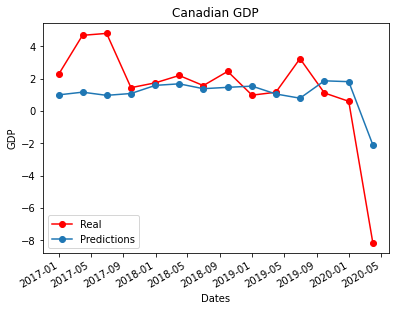

In [32]:
import matplotlib.dates as mdates
fig = plt.figure()
axes = fig.add_axes([0.2,0.2,0.8,0.8])
axes.plot(compare['day_datetime'],compare['real'],'r',marker='o',label='Real')
axes.plot(compare['day_datetime'],compare['forecast'],marker='o',label='Predictions')
axes.set_xlabel('Dates')
axes.set_ylabel('GDP')
axes.set_title('Canadian GDP')
axes.legend()
plt.tight_layout
fig.autofmt_xdate()
# This format code is not working\n",
#axes.fmt_xdata = mdates.DateFormatter('%YY-%mm')\n",
# Use a more precise date string for the x axis locations in the toolbar.\n",
plt.show()